<a href="https://colab.research.google.com/github/lygitdata/STATS-415-Project/blob/main/code/STATS_415_Kaggle_Li_Yuan.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Import necessary libraries
import random
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from sklearn.model_selection import train_test_split, GridSearchCV, KFold, StratifiedKFold
from sklearn import preprocessing
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
import matplotlib.pyplot as plt
import xgboost as xgb
from datetime import datetime
# Runtime control
runNN = True
runXGB = False

In [ ]:
def timer(start_time=None):
    if not start_time:
        start_time = datetime.now()
        return start_time
    elif start_time:
        thour, temp_sec = divmod((datetime.now() - start_time).total_seconds(), 3600)
        tmin, tsec = divmod(temp_sec, 60)
        print('\n Time taken: %i hours %i minutes and %s seconds.' % (thour, tmin, round(tsec, 2)))

# Data Cleaning

In [ ]:
# Import training set
X_train = pd.read_csv('https://lygitdata.github.io/STATS-415-Project/kaggleData/X_train.csv')
y_train = pd.read_csv('https://lygitdata.github.io/STATS-415-Project/kaggleData/y_train.csv')
# Import testing set
X_test = pd.read_csv('https://lygitdata.github.io/STATS-415-Project/kaggleData/X_test.csv')
y_sample = pd.read_csv('https://lygitdata.github.io/STATS-415-Project/kaggleData/y_sample.csv')

# Dummy variable transform
categorical_cols = ['self_eval', 'teacher_eval', 'district']
X_train = pd.get_dummies(X_train, columns=categorical_cols, drop_first=True)
print(X_train.shape)
X_test = pd.get_dummies(X_test, columns=categorical_cols, drop_first=True)
print(X_test.shape)

# Drop and save SEQN
SEQN_X_train = X_train['SEQN']
X_train = X_train.drop(columns=['SEQN'])
SEQN_y_train = y_train['SEQN']
y_train = y_train.drop(columns=['SEQN'])
SEQN_X_test = X_test['SEQN']
X_test = X_test.drop(columns=['SEQN'])

(8000, 65)
(4000, 65)


In [ ]:
# Scale data
scaler = preprocessing.StandardScaler()
minmax = preprocessing.MinMaxScaler()
X_train[['self_eval_2', 'self_eval_3', 'self_eval_4', 'self_eval_5',
       'district_2', 'district_3', 'district_4', 'district_5', 'district_6',
       'district_7']] = scaler.fit_transform(X_train[[
       'self_eval_2', 'self_eval_3', 'self_eval_4', 'self_eval_5',
       'district_2', 'district_3', 'district_4', 'district_5', 'district_6',
       'district_7']])
X_test[['self_eval_2', 'self_eval_3', 'self_eval_4', 'self_eval_5',
       'district_2', 'district_3', 'district_4', 'district_5', 'district_6',
       'district_7']] = scaler.fit_transform(X_test[[
       'self_eval_2', 'self_eval_3', 'self_eval_4', 'self_eval_5',
       'district_2', 'district_3', 'district_4', 'district_5', 'district_6',
       'district_7']])
X_train[['teacher_eval_2', 'teacher_eval_3',
         'teacher_eval_4', 'teacher_eval_5']] = scaler.fit_transform(X_train[['teacher_eval_2', 'teacher_eval_3',
                                                                              'teacher_eval_4', 'teacher_eval_5']])
X_test[['teacher_eval_2', 'teacher_eval_3',
        'teacher_eval_4', 'teacher_eval_5']] = scaler.fit_transform(X_test[['teacher_eval_2', 'teacher_eval_3',
                                                                            'teacher_eval_4', 'teacher_eval_5']])
# Convert data to numpy arrays
X_train = X_train.to_numpy()
y_train = y_train.to_numpy()
X_test = X_test.to_numpy()

# Model Training (Neural Network)

In [ ]:
if runNN:
  lr_schedule = keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=0.001,
    decay_steps=20000,
    decay_rate=0.955,
  )

  callbacks = [
    keras.callbacks.EarlyStopping(
        monitor='val_r2_score',
        patience=20,
        restore_best_weights=True,
        mode='max'
    ),
    keras.callbacks.ModelCheckpoint(
        "best_model.h5",
        save_best_only=True,
        monitor='val_r2_score',
        mode='max'
    )
  ]

  def build_model():
    nn_model = Sequential([
        layers.Dense(units=2, activation='elu'),
        #layers.Dense(units=4096, activation='elu'),
        layers.BatchNormalization(),
        #layers.Dropout(0.3),
        #layers.Dense(units=2048, activation='relu'),
        #layers.BatchNormalization(),
        #layers.Dropout(0.5),
        #layers.Dense(units=512, activation='relu'),
        #layers.BatchNormalization(),
        #layers.Dropout(0.3),
        layers.Dense(units=1, activation='linear')
    ])

    nn_model.compile(
        optimizer=keras.optimizers.AdamW(learning_rate=lr_schedule),
        loss="mean_squared_error",
        metrics=[tf.keras.metrics.R2Score(name='r2_score')]
    )

    return nn_model

  kf = KFold(n_splits=20, shuffle=True, random_state=88)

  mse_scores = []
  r2_scores = []
  i = 0
  for train_index, val_index in kf.split(X_train):
    i = i + 1
    X_train_fold, X_val_fold = X_train[train_index], X_train[val_index]
    y_train_fold, y_val_fold = y_train[train_index], y_train[val_index]

    nn_model = build_model()
    history = nn_model.fit(
        X_train_fold, y_train_fold,
        epochs=300,
        batch_size=512,
        validation_data=(X_val_fold, y_val_fold),
        callbacks=callbacks,
        verbose=0
    )

    y_val_pred = nn_model.predict(X_val_fold, verbose=False)
    mse = mean_squared_error(y_val_fold, y_val_pred)
    mse_scores.append(mse)
    r2 = r2_score(y_val_fold, y_val_pred)
    r2_scores.append(r2)
    print(i, "Fold | Validation MSE =", round(mse, 5), " | Validation Adjusted R^2 =", round(r2, 5))

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


1 Fold | Validation MSE = 0.27848  | Validation Adjusted R^2 = 0.88866


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


2 Fold | Validation MSE = 0.23947  | Validation Adjusted R^2 = 0.89881
3 Fold | Validation MSE = 0.24051  | Validation Adjusted R^2 = 0.88914


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


4 Fold | Validation MSE = 0.24685  | Validation Adjusted R^2 = 0.90296
5 Fold | Validation MSE = 0.24117  | Validation Adjusted R^2 = 0.87973
6 Fold | Validation MSE = 0.24  | Validation Adjusted R^2 = 0.88545


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


7 Fold | Validation MSE = 0.2498  | Validation Adjusted R^2 = 0.90726
8 Fold | Validation MSE = 0.2573  | Validation Adjusted R^2 = 0.88852
9 Fold | Validation MSE = 0.26429  | Validation Adjusted R^2 = 0.87666
10 Fold | Validation MSE = 0.24069  | Validation Adjusted R^2 = 0.89936
11 Fold | Validation MSE = 0.23288  | Validation Adjusted R^2 = 0.90191
12 Fold | Validation MSE = 0.25951  | Validation Adjusted R^2 = 0.89523
13 Fold | Validation MSE = 0.23897  | Validation Adjusted R^2 = 0.89153
14 Fold | Validation MSE = 0.2695  | Validation Adjusted R^2 = 0.86618
15 Fold | Validation MSE = 0.22629  | Validation Adjusted R^2 = 0.90413
16 Fold | Validation MSE = 0.25048  | Validation Adjusted R^2 = 0.89309
17 Fold | Validation MSE = 0.2666  | Validation Adjusted R^2 = 0.8803
18 Fold | Validation MSE = 0.26316  | Validation Adjusted R^2 = 0.88971
19 Fold | Validation MSE = 0.26195  | Validation Adjusted R^2 = 0.89042
20 Fold | Validation MSE = 0.21491  | Validation Adjusted R^2 = 0.89889


Mean MSE = 0.24913956270550006
Std Dev MSE = 0.015492556141903683
Mean Adj. R^2 = 0.8913967567102645
Std Dev Adj. R^2 =  0.01005550573990023


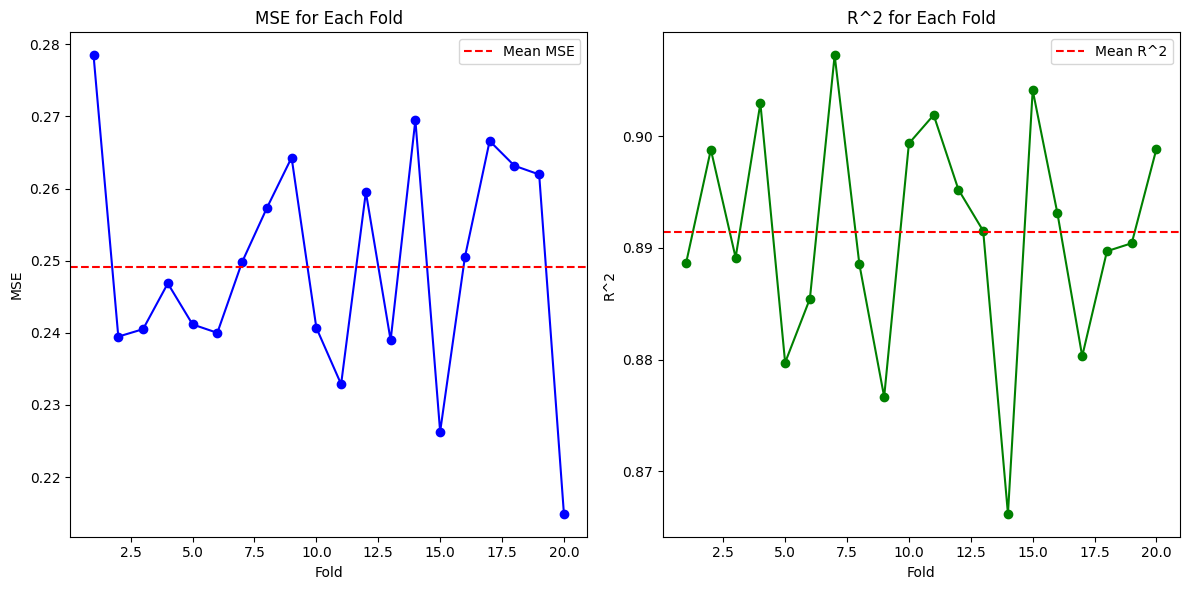

In [ ]:
if runNN:
  print("Mean MSE =", np.mean(mse_scores))
  print("Std Dev MSE =", np.std(mse_scores))
  print("Mean Adj. R^2 =", np.mean(r2_scores))
  print("Std Dev Adj. R^2 = ", np.std(r2_scores))

  # Plot MSEs
  plt.figure(figsize=(12, 6))
  plt.subplot(1, 2, 1)
  plt.plot(range(1, len(mse_scores) + 1), mse_scores, marker='o', linestyle='-', color='b')
  plt.axhline(y=np.mean(mse_scores), color='r', linestyle='--', label='Mean MSE')
  plt.title('MSE for Each Fold')
  plt.xlabel('Fold')
  plt.ylabel('MSE')
  plt.legend()

  # Plot R^2s
  plt.subplot(1, 2, 2)
  plt.plot(range(1, len(r2_scores) + 1), r2_scores, marker='o', linestyle='-', color='g')
  plt.axhline(y=np.mean(r2_scores), color='r', linestyle='--', label='Mean R^2')
  plt.title('R^2 for Each Fold')
  plt.xlabel('Fold')
  plt.ylabel('R^2')
  plt.legend()

  plt.tight_layout()
  plt.show()

In [ ]:
if runNN:
  y_test = nn_model.predict(X_test)
  output = pd.DataFrame({'SEQN': SEQN_X_test.values.flatten(), 'y': y_test.flatten()})
  out = y_sample.merge(output, on=['SEQN'], how="left")
  out = out.drop(columns=['y_x'])
  out = out.rename(columns={'y_y': 'y'})
  out

125/125 [==============================] - 0s 3ms/step


In [ ]:
if runNN:
  out.to_csv('nn_result.csv', index=False)

# Model Training (XGBoost)

In [ ]:
if runXGB:
  params = {
      'objective': ['reg:squarederror'],
      'eval_metric': ['rmse'],
      'gamma': [0.5, 0.75, 1, 1.25, 1.5, 2, 2.5, 3, 4, 5],
      'eta': [0.001, 0.0015, 0.002, 0.003, 0.005, 0.01, 0.05, 0.1],
      'max_depth': [3, 4, 5, 6, 9, 10, 11, 12],
      'subsample': [0.5, 0.6, 0.7, 0.8, 0.9, 1.0],
      'colsample_bytree': [0.5, 0.6, 0.7, 0.8, 0.9, 1.0],
      'seed': [88],
      'n_estimators': [100, 150, 200, 250, 300, 350, 400,
                    450, 500, 550, 600, 650, 700, 750,
                    800, 850, 900, 950, 1000]
  }
  xgb_model = xgb.XGBRegressor()

In [ ]:
if runXGB:
  kf = KFold(n_splits=10, shuffle=True, random_state=88)
  grid_search = GridSearchCV(estimator = xgb_model,
                            param_grid = params,
                            scoring='neg_mean_squared_error',
                            cv = kf,
                            verbose = 3,
                            n_jobs = -1)
  start_time = timer(None)
  grid_search.fit(X_train, y_train)
  timer(start_time)
  print('\n All results:')
  print(grid_search.cv_results_)

In [ ]:
if runXGB:
  best_model = grid_search.best_estimator_
  y_pred = best_model.predict(X_train)
  mse = mean_squared_error(y_train, y_pred)
  r2 = r2_score(y_train, y_pred)
  print('\n Best Model:')
  print('MSE:', mse)
  print('R^2:', r2)
  print('Best Hyperparameters:', grid_search.best_params_)